# Advanced model analysis

In [2]:
#Import libraries and modules

import time
import pandas as pd
import dill

import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import tensorflow as tf
#import autokeras as ak

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [3]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1]) 
    return tup 

In [4]:
# Use the following only on the training data, not the validation one
# We will mostly use Standardize
# Should we normalize/standardize the Fantasy Points column? I think so...
def data_Normalize(data, target_col):
    newData=data.copy()
    
    for c in list(target_col):
        # First exception shouldn't happen since we deal with strings before
        if (not isinstance(data.loc[ data.index[0],c], str)) :
            minval=np.min(data[c])
            maxval=np.max(data[c])
            newData[c]=(data[c]-minval)/(maxval-minval)
            
    return newData

def data_Standardize(data, target_col):
    newData=data.copy()
    
    for c in list(data.columns):
        # First exception shouldn't happen since we deal with strings before
        if (not isinstance(data.loc[ data.index[0],c], str)) :
            avg=np.mean(data[c])
            std=np.std(data[c])
            newData[c]=(data[c]-avg)/std
            
    return newData

In [5]:
# Import data
dill_file = open("all_data_adv_v1", "rb")
all_cleaned_data = dill.load(dill_file)
dill_file.close()

In [81]:
dill_file = open("all_col_names", "rb")
col_dict = dill.load(dill_file)
dill_file.close()
# Column dictionary for subset of column
# Create a sub-dictionary for the selected columns
adv_col=[0,3,1,2,4,7,24,11,306,304,309,39,40,308,29,28,46,47,
                             126,127,130,131,133,137,223,224,225,229,232,321]
adv_col_dict={}
for i,j in enumerate(adv_col):
    adv_col_dict[i]=('S1',list(col_dict[j])[1])
for i,j in enumerate(adv_col):
    adv_col_dict[i+len(adv_col)]=('S2',list(col_dict[j])[1])
adv_col_dict

{0: ('S1', 'Name'),
 1: ('S1', 'Season'),
 2: ('S1', 'Fantasy Points'),
 3: ('S1', 'Position'),
 4: ('S1', 'Age'),
 5: ('S1', 'GP'),
 6: ('S1', 'ATOI'),
 7: ('S1', '+/-'),
 8: ('S1', 'PTS'),
 9: ('S1', 'G'),
 10: ('S1', 'S'),
 11: ('S1', 'TSA'),
 12: ('S1', 'SThr%'),
 13: ('S1', 'PIM'),
 14: ('S1', 'HIT'),
 15: ('S1', 'BLK'),
 16: ('S1', 'TK'),
 17: ('S1', 'GV'),
 18: ('S1', 'CF%'),
 19: ('S1', 'CF% rel'),
 20: ('S1', 'FF%'),
 21: ('S1', 'FF% rel'),
 22: ('S1', 'oiSH%'),
 23: ('S1', 'oZS%'),
 24: ('S1', 'PTS/60'),
 25: ('S1', 'S/60'),
 26: ('S1', 'oiGF/60'),
 27: ('S1', 'C/60'),
 28: ('S1', 'F/60'),
 29: ('S1', 'PS'),
 30: ('S2', 'Name'),
 31: ('S2', 'Season'),
 32: ('S2', 'Fantasy Points'),
 33: ('S2', 'Position'),
 34: ('S2', 'Age'),
 35: ('S2', 'GP'),
 36: ('S2', 'ATOI'),
 37: ('S2', '+/-'),
 38: ('S2', 'PTS'),
 39: ('S2', 'G'),
 40: ('S2', 'S'),
 41: ('S2', 'TSA'),
 42: ('S2', 'SThr%'),
 43: ('S2', 'PIM'),
 44: ('S2', 'HIT'),
 45: ('S2', 'BLK'),
 46: ('S2', 'TK'),
 47: ('S2', 'GV')

# Model Fit -- PPG

In [7]:
# Drop name column
fitData=all_cleaned_data.drop(0, axis=1)
fitData

,Target FPPG,Target PPG,1,2,3,4,5,6,7,8,...,48,49,50,51,52,53,54,55,56,57
0,10.627130,1.01,9,11.34878,1.0,24.0,1.0,0.3125,0.365854,1.15,...,0.634,0.16,0.1,0.71,2.7,10.9,3.7,28.3,21.7,8.9
1,10.591260,0.83,9,9.237662,1.0,32.0,0.939024,0.309444,0.219512,1.01,...,0.631,0.146,0.085,0.622,2.4,11.6,3.1,27.0,21.0,6.5
2,6.976437,0.75,9,8.050617,1.0,33.0,0.987805,0.301667,0.304878,0.85,...,0.586,0.076,0.09,0.637,2.1,7.8,2.9,18.9,13.2,4.0
3,7.585366,0.82,9,7.20122,1.0,23.0,1.0,0.310833,0.402439,0.76,...,0.615,0.123,0.075,0.643,1.5,6.8,2.5,25.1,17.9,2.7
4,11.554045,0.75,9,7.125926,1.0,30.0,0.987805,0.282778,0.146341,0.74,...,0.613,0.129,0.08,0.657,2.1,10.3,2.8,23.2,18.4,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6371,6.768388,0.45,20,3.048571,1.0,40.0,0.853659,0.258333,-0.231707,0.44,...,0.6,0.083,0.11,0.599,2.7,4.8,4.0,23.5,16.7,4.8
6372,4.524138,0.17,20,2.275758,1.0,27.0,0.804878,0.230833,-0.146341,0.27,...,0.499,-0.054,0.1,0.537,1.7,5.7,3.0,2.1,-0.2,3.1
6373,3.445829,0.12,20,3.051429,0.0,32.0,0.853659,0.338333,-0.121951,0.21,...,0.456,-0.13,0.103,0.364,1.0,4.0,2.9,-9.5,-7.5,3.2
6374,4.070970,0.24,20,2.154,1.0,23.0,0.609756,0.199167,-0.097561,0.22,...,0.43,-0.049,0.045,0.459,0.0,5.2,0.9,-7.8,-9.6,-0.1


Let us begin by visualizing the data. We expect PPG to be positively proportional to PPG in the following year.

<function matplotlib.pyplot.show(close=None, block=None)>

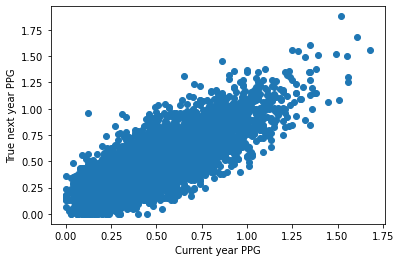

In [8]:
plt.scatter(fitData[8], fitData['Target PPG'])
plt.xlabel("Current year PPG")
plt.ylabel("True next year PPG")
plt.show

In [9]:
# Regression task: Assume players maintain EXACT same production the next year
MSE=np.mean((fitData[8]-fitData['Target PPG'])**2)
print(f'MSE: {MSE}')
print(f'RMSE: {np.sqrt(MSE)}')

MSE: 0.023317440401505834
RMSE: 0.1527004924730298


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    fitData.drop('Target PPG',axis=1).drop('Target FPPG',axis=1).drop(1,axis=1), fitData['Target PPG'], test_size=0.15)

In [11]:
# Linear Regression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) #training the algorithm
lin_res=lin_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(lin_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(lin_res,y_test))}')

MSE: 0.017007180602300054
RMSE: 0.13041158154972302


We see a small improvement

MSE: 0.01928961805496235
RMSE: 0.13888706943039136


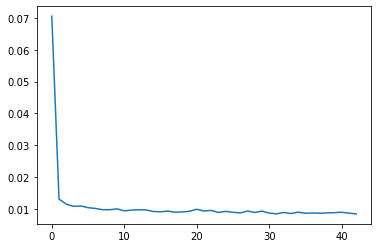

In [12]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(256,128,64,64,32,16),activation="relu", solver='adam', learning_rate='adaptive' ,random_state=2, max_iter=3000).fit(X_train, y_train)
mlp_res = mlp_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(mlp_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(mlp_res,y_test))}')
plt.plot(mlp_reg.loss_curve_)

In [13]:
X_train.shape

(5419, 56)

Epoch 1/40
28/28 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0246
Epoch 2/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0237
Epoch 3/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0210
Epoch 4/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0201
Epoch 5/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0213 - val_loss: 0.0205
Epoch 6/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0214 - val_loss: 0.0203
Epoch 7/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0229
Epoch 8/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 9/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0200 - val_loss: 0.0212
Epoch 10/40
28/28 [==============================] - 0s 2ms/step - loss: 0.0194 - val_loss: 0.0205
Epoch 11/40
28/28 [

<function matplotlib.pyplot.show(close=None, block=None)>

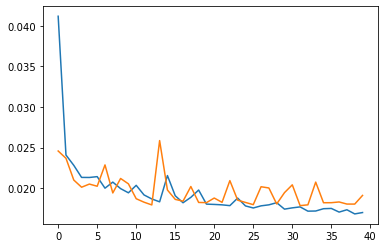

In [29]:
model = Sequential()
model.add(Dense(256, input_dim=56, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
history=model.fit(tf.convert_to_tensor(X_train, np.float64), tf.convert_to_tensor(y_train, np.float64), 
                  epochs=40, batch_size=200,
                  validation_data=(tf.convert_to_tensor(X_test, np.float64), tf.convert_to_tensor(y_test, np.float64)) )
#Plot loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.show

In [15]:
'''
import autokeras as ak

ak_reg = ak.StructuredDataRegressor(
    loss="mean_squared_error",
    max_trials=10,  # It tries 10 different models.
    overwrite=True,
)
history=ak_reg.fit(
    x=tf.convert_to_tensor(X_train, np.float64), 
    y=tf.convert_to_tensor(y_train, np.float64), 
    epochs=50, 
    #callbacks=None, 
    #validation_split=0.2, 
    validation_data=(tf.convert_to_tensor(X_test, np.float64), tf.convert_to_tensor(y_test, np.float64)), 
)'''

'\nimport autokeras as ak\n\nak_reg = ak.StructuredDataRegressor(\n    loss="mean_squared_error",\n    max_trials=10,  # It tries 10 different models.\n    overwrite=True,\n)\nhistory=ak_reg.fit(\n    x=tf.convert_to_tensor(X_train, np.float64), \n    y=tf.convert_to_tensor(y_train, np.float64), \n    epochs=50, \n    #callbacks=None, \n    #validation_split=0.2, \n    validation_data=(tf.convert_to_tensor(X_test, np.float64), tf.convert_to_tensor(y_test, np.float64)), \n)'

Let's make predictions for the 2022 season

In [16]:
# Import data for 2022 to test as target
# Target columns are meaningless since we didn't collect 2022 season data.
# One should consult current daily stats to compare
dill_file = open("all_data_adv_test", "rb")
all2022 = dill.load(dill_file)
dill_file.close()
all2022.index=range(len(all2022.index))
all2022=all2022.fillna(0)
X2022=all2022.drop('Target FPPG', axis=1).drop('Target PPG', axis=1).drop(0, axis=1).drop(1, axis=1)

In [17]:
# Linear model prediction
lin_pred=lin_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(lin_pred)[-20:]):
    indices.append(np.where(lin_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, FPPG: {all2022.loc[ind,2]}, PPG: {all2022.loc[ind,8]})')

[(0, 0.863677978515625),
 (21, 0.868072509765625),
 (22, 0.8747406005859375),
 (107, 0.8831939697265625),
 (108, 0.912078857421875),
 (174, 0.9311370849609375),
 (175, 0.93743896484375),
 (216, 0.9493560791015625),
 (218, 0.9505767822265625),
 (262, 0.951995849609375),
 (263, 1.0086822509765625),
 (336, 1.03564453125),
 (337, 1.03887939453125),
 (357, 1.0694427490234375),
 (358, 1.090484619140625),
 (379, 1.0932769775390625),
 (470, 1.16558837890625),
 (471, 1.170806884765625),
 (474, 1.333892822265625),
 (491, 1.510894775390625)]

Predicted: (Name:Sebastian Aho, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Jonathan Huberdeau, FPPG: 8.66909090909091, PPG: 1.11)
Predicted: (Name:Aleksander Barkov, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Patrick Kane, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:Alex DeBrincat, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Sidney Crosby, FPPG: 9.583636363636364, PPG: 1.13)
Predicted: (Name:Jake Guentzel, FPPG: 8.623214285714285, PPG: 1.02)
Predicted: (Name:Brad Marchand3, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mika Zibanejad, FPPG: 8.533928571428572, PPG: 0.89)
Predicted: (Name:Mitch Marner, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, FPPG: 12.20

In [18]:
# MLP model prediction
mlp_pred=mlp_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(mlp_pred)[-20:]):
    indices.append(np.where(mlp_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, FPPG: {all2022.loc[ind,2]}, PPG: {all2022.loc[ind,8]})')

[(0, 0.8245314530392964),
 (21, 0.8280597625810105),
 (22, 0.844128170390697),
 (108, 0.8935884145958756),
 (174, 0.906450670843952),
 (175, 0.9157014947635689),
 (216, 0.9168553633725368),
 (218, 0.9334612870097739),
 (262, 0.94666521561838),
 (336, 0.9871150946429961),
 (337, 0.9889150052020979),
 (357, 1.0225015417413537),
 (358, 1.0481346613380114),
 (379, 1.0908413029512718),
 (456, 1.097100826210279),
 (470, 1.118630473811455),
 (471, 1.1609328388271671),
 (472, 1.287724767481698),
 (474, 1.4118649204859683),
 (491, 1.4799616585358137)]

Predicted: (Name:Sebastian Aho, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Jonathan Huberdeau, FPPG: 8.66909090909091, PPG: 1.11)
Predicted: (Name:Aleksander Barkov, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Alex DeBrincat, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Sidney Crosby, FPPG: 9.583636363636364, PPG: 1.13)
Predicted: (Name:Jake Guentzel, FPPG: 8.623214285714285, PPG: 1.02)
Predicted: (Name:Brad Marchand3, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mitch Marner, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, FPPG: 12.200000000000001, PPG: 1.5)
Predicted: (Name:Mark Scheifele, FPPG: 8.417857142857143, PPG: 1.13)
Predicted: (Name:Elias Pettersson, FPPG: 6

In [42]:
# keras model prediction
keras_pred=model.predict(tf.convert_to_tensor(X2022, np.float64))
indices=[]
vals=[]
for j in list(np.sort(keras_pred.flatten())[-20:]):
    indices.append(np.where(keras_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, FPPG: {all2022.loc[ind,2]}, PPG: {all2022.loc[ind,8]})')

[(0, 0.894943),
 (21, 0.90363705),
 (22, 0.9072045),
 (108, 0.9245384),
 (174, 0.9273483),
 (175, 0.927861),
 (216, 0.9442177),
 (218, 0.9513394),
 (239, 0.96756864),
 (262, 0.97842807),
 (336, 0.9789121),
 (337, 0.98018986),
 (357, 0.98161805),
 (358, 0.9919404),
 (379, 0.9920654),
 (456, 0.99687254),
 (470, 0.9968966),
 (471, 0.996955),
 (474, 0.9982525),
 (491, 0.9995021)]

Predicted: (Name:Sebastian Aho, FPPG: 8.967857142857143, PPG: 1.02)
Predicted: (Name:Jonathan Huberdeau, FPPG: 8.66909090909091, PPG: 1.11)
Predicted: (Name:Aleksander Barkov, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Alex DeBrincat, FPPG: 9.451923076923077, PPG: 1.08)
Predicted: (Name:Sidney Crosby, FPPG: 9.583636363636364, PPG: 1.13)
Predicted: (Name:Jake Guentzel, FPPG: 8.623214285714285, PPG: 1.02)
Predicted: (Name:Brad Marchand3, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Mathew Barzal, FPPG: 7.156363636363637, PPG: 0.82)
Predicted: (Name:Artemi Panarin, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mitch Marner, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, FPPG: 12.200000000000001, PPG: 1.5)
Predicted: (Name:Mark Scheifele, FPPG: 8.41

# Model Fit -- FPPG

<function matplotlib.pyplot.show(close=None, block=None)>

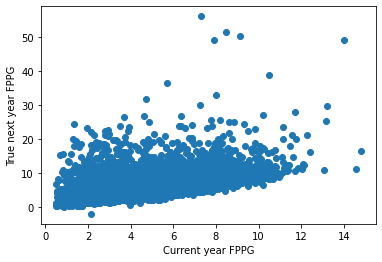

In [43]:
plt.scatter(fitData[2], fitData['Target FPPG'])
plt.xlabel("Current year FPPG")
plt.ylabel("True next year FPPG")
plt.show

In [44]:
# Regression task: Assume players maintain EXACT same production the next year. Based on figure above, unlikely to work
MSE=np.mean((fitData[2]-fitData['Target FPPG'])**2)
print(f'MSE: {MSE}')
print(f'RMSE: {np.sqrt(MSE)}')

MSE: 14.184864186673096
RMSE: 3.7662798869272973


In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    fitData.drop('Target PPG',axis=1).drop('Target FPPG',axis=1).drop(1,axis=1), fitData['Target FPPG'], test_size=0.15)

In [67]:
# Linear Regression
lin_reg = LinearRegression()  
lin_reg.fit(X_train, y_train) #training the algorithm
lin_res=lin_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(lin_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(lin_res,y_test))}')

MSE: 12.484991931552116
RMSE: 3.5334108070746764


Iteration 1, loss = 12.22706765
Iteration 2, loss = 5.71929121
Iteration 3, loss = 5.32460462
Iteration 4, loss = 5.12119005
Iteration 5, loss = 5.23266513
Iteration 6, loss = 5.13173581
Iteration 7, loss = 5.04357520
Iteration 8, loss = 5.08821195
Iteration 9, loss = 5.06472704
Iteration 10, loss = 5.03466113
Iteration 11, loss = 5.16591123
Iteration 12, loss = 5.04416865
Iteration 13, loss = 4.96954163
Iteration 14, loss = 4.96539303
Iteration 15, loss = 4.86814663
Iteration 16, loss = 4.91223764
Iteration 17, loss = 4.80955061
Iteration 18, loss = 4.76905659
Iteration 19, loss = 4.76839515
Iteration 20, loss = 4.99836997
Iteration 21, loss = 4.78415292
Iteration 22, loss = 4.75166943
Iteration 23, loss = 4.72306222
Iteration 24, loss = 4.70273668
Iteration 25, loss = 4.73874336
Iteration 26, loss = 4.74715170
Iteration 27, loss = 4.75768131
Iteration 28, loss = 4.69008081
Iteration 29, loss = 4.60762347
Iteration 30, loss = 4.64349567
Iteration 31, loss = 4.88324889
Iteration 32, lo

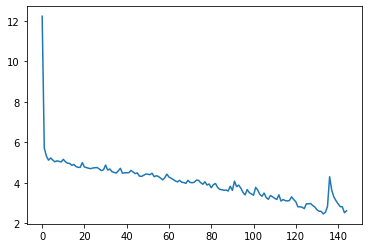

In [69]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(512,256,256,128,128,64,64,32,16),activation="relu", solver='adam', learning_rate='adaptive' ,random_state=1, max_iter=500, tol=1e-7, verbose=True).fit(X_train, y_train)
mlp_res=mlp_reg.predict(X_test)
print(f'MSE: {metrics.mean_squared_error(mlp_res,y_test)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(mlp_res,y_test))}')
plt.plot(mlp_reg.loss_curve_)

Epoch 1/50
28/28 [==============================] - 1s 20ms/step - loss: 48.1503 - val_loss: 55.3742
Epoch 2/50
28/28 [==============================] - 0s 16ms/step - loss: 47.5849 - val_loss: 54.6777
Epoch 3/50
28/28 [==============================] - 0s 16ms/step - loss: 46.8272 - val_loss: 53.7627
Epoch 4/50
28/28 [==============================] - 0s 17ms/step - loss: 45.8659 - val_loss: 52.6598
Epoch 5/50
28/28 [==============================] - 0s 17ms/step - loss: 44.8287 - val_loss: 51.6486
Epoch 6/50
28/28 [==============================] - 0s 17ms/step - loss: 43.9981 - val_loss: 50.9834
Epoch 7/50
28/28 [==============================] - 0s 17ms/step - loss: 43.5024 - val_loss: 50.6279
Epoch 8/50
28/28 [==============================] - 1s 19ms/step - loss: 43.2452 - val_loss: 50.4460
Epoch 9/50
28/28 [==============================] - 1s 19ms/step - loss: 43.1124 - val_loss: 50.3518
Epoch 10/50
28/28 [==============================] - 1s 20ms/step - loss: 43.0406 - val_los

<function matplotlib.pyplot.show(close=None, block=None)>

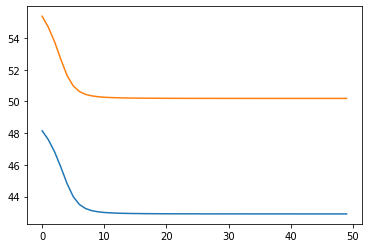

In [80]:
opt=tf.keras.optimizers.Adam(
    learning_rate=0.000005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)

model = Sequential()
model.add(Dense(1024, input_dim=56, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer=opt)
history=model.fit(tf.convert_to_tensor(X_train, np.float64), tf.convert_to_tensor(y_train, np.float64), 
                  epochs=50, batch_size=200,
                  validation_data=(tf.convert_to_tensor(X_test, np.float64), tf.convert_to_tensor(y_test, np.float64)) )
#Plot loss
plt.plot(history.history['loss'] )
plt.plot(history.history['val_loss'] )
plt.show

In [71]:
# Import data for 2022 to test as target
# Target columns are meaningless since we didn't collect 2022 season data.
# One should consult current daily stats to compare
dill_file = open("all_data_adv_test", "rb")
all2022 = dill.load(dill_file)
dill_file.close()
all2022.index=range(len(all2022.index))
all2022=all2022.fillna(0)
X2022=all2022.drop('Target FPPG', axis=1).drop('Target PPG', axis=1).drop(0, axis=1).drop(1, axis=1)

In [72]:
# Linear model prediction
lin_pred=lin_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(lin_pred)[-20:]):
    indices.append(np.where(lin_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, FPPG: {all2022.loc[ind,2]}, PPG: {all2022.loc[ind,8]})')

[(3, 10.983483661528874),
 (22, 10.997823184510166),
 (63, 11.024694481564197),
 (107, 11.138162608200359),
 (198, 11.14832879526955),
 (200, 11.27751351998316),
 (216, 11.291199335067093),
 (217, 11.426988648322876),
 (218, 11.444881767995115),
 (262, 11.674819252027156),
 (263, 11.774324078004128),
 (336, 11.815840312056274),
 (337, 12.218109571161502),
 (357, 12.35263402647907),
 (358, 12.372070363782344),
 (379, 12.529730375733184),
 (470, 13.769821222287478),
 (471, 13.905096764864993),
 (474, 14.743563381909986),
 (492, 16.16113535360431)]

Predicted: (Name:Dougie Hamilton, FPPG: 8.909090909090908, PPG: 0.76)
Predicted: (Name:Aleksander Barkov, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Roman Josi, FPPG: 7.58125, PPG: 0.69)
Predicted: (Name:Patrick Kane, FPPG: 9.123214285714285, PPG: 1.18)
Predicted: (Name:John Carlson, FPPG: 7.696153846153846, PPG: 0.85)
Predicted: (Name:Alex Ovechkin, FPPG: 9.395555555555555, PPG: 0.93)
Predicted: (Name:Brad Marchand3, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:Patrice Bergeron, FPPG: 9.588888888888889, PPG: 0.89)
Predicted: (Name:David Pastrnak, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Artemi Panarin, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mika Zibanejad, FPPG: 8.533928571428572, PPG: 0.89)
Predicted: (Name:Mitch Marner, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, FPPG: 12.200000000000001,

In [73]:
# MLP model prediction
mlp_pred=mlp_reg.predict(X2022)
indices=[]
vals=[]
for j in list(np.sort(mlp_pred)[-20:]):
    indices.append(np.where(mlp_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, FPPG: {all2022.loc[ind,2]}, PPG: {all2022.loc[ind,8]})')

[(22, 12.678970060909256),
 (61, 12.88614001626043),
 (216, 13.02163526456125),
 (218, 13.088438440513803),
 (259, 13.23131873677096),
 (262, 13.237677677841305),
 (263, 13.288434903615274),
 (266, 13.5544429217398),
 (314, 13.605848923624848),
 (336, 13.678311364871355),
 (337, 14.525054325672707),
 (357, 14.57619887894876),
 (358, 14.765853765064405),
 (433, 15.019616959556556),
 (470, 15.036082670434247),
 (471, 19.35633443189351),
 (474, 19.562983526546237),
 (491, 19.874601791089404),
 (492, 26.09967660962096),
 (609, 26.957447456785538)]

Predicted: (Name:Aleksander Barkov, FPPG: 10.828, PPG: 1.16)
Predicted: (Name:Luke Schenn, FPPG: 2.0973684210526318, PPG: 0.11)
Predicted: (Name:Brad Marchand3, FPPG: 10.59811320754717, PPG: 1.3)
Predicted: (Name:David Pastrnak, FPPG: 9.404166666666667, PPG: 1.0)
Predicted: (Name:Kieffer Bellows, FPPG: 2.8642857142857143, PPG: 0.21)
Predicted: (Name:Artemi Panarin, FPPG: 10.295238095238094, PPG: 1.38)
Predicted: (Name:Mika Zibanejad, FPPG: 8.533928571428572, PPG: 0.89)
Predicted: (Name:Adam Fox, FPPG: 8.65090909090909, PPG: 0.85)
Predicted: (Name:Jesper Boqvist, FPPG: 2.3785714285714286, PPG: 0.25)
Predicted: (Name:Mitch Marner, FPPG: 10.17090909090909, PPG: 1.22)
Predicted: (Name:Auston Matthews, FPPG: 12.707692307692307, PPG: 1.27)
Predicted: (Name:Connor McDavid, FPPG: 14.392857142857142, PPG: 1.88)
Predicted: (Name:Leon Draisaitl, FPPG: 12.200000000000001, PPG: 1.5)
Predicted: (Name:Michael Stone, FPPG: 3.9000000000000004, PPG: 0.19)
Predicted: (Name:Mikko Rantanen, FPPG: 11.755769

In [76]:
keras_pred=model.predict(tf.convert_to_tensor(X2022, np.float64))
keras_pred

array([[0.99962795],
       [0.9994014 ],
       [0.99970734],
       [0.99982166],
       [0.9982016 ],
       [0.9995218 ],
       [0.99958056],
       [0.9981498 ],
       [0.9972515 ],
       [0.9993366 ],
       [0.9996556 ],
       [0.99876916],
       [0.9980469 ],
       [0.99839747],
       [0.9992424 ],
       [0.99951196],
       [0.99924886],
       [0.99879175],
       [0.99876213],
       [0.9991139 ],
       [0.9961335 ],
       [0.99976337],
       [0.9995761 ],
       [0.9988107 ],
       [0.9986377 ],
       [0.9999242 ],
       [0.99882805],
       [0.99753654],
       [0.99987423],
       [0.99871   ],
       [0.9984343 ],
       [0.99714524],
       [0.9997275 ],
       [0.9993441 ],
       [0.9996455 ],
       [0.9974178 ],
       [0.9997785 ],
       [0.9979202 ],
       [0.99931765],
       [0.99852   ],
       [0.998355  ],
       [0.9979404 ],
       [0.9984143 ],
       [0.9981012 ],
       [0.99952126],
       [0.9995233 ],
       [0.999673  ],
       [0.998

In [ ]:
# keras model prediction
keras_pred=model.predict(tf.convert_to_tensor(X2022, np.float64))
indices=[]
vals=[]
for j in list(np.sort(keras_pred.flatten())[-20:]):
    indices.append(np.where(keras_pred==j)[0])
    vals.append(j)
top10=np.unique(np.concatenate(indices))
pair=[]
for i,j in enumerate(top10):
    pair.append((j, vals[i]))
display(pair)
for j in Sort_Tuple(pair):
    ind=j[0]
    print(f'Predicted: (Name:{all2022.loc[ind,0]}, FPPG: {all2022.loc[ind,2]}, PPG: {all2022.loc[ind,8]})')